# Solution to a Relax Challenge

First import all necessary modules

In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

In [247]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

### Load data from both files

In [248]:
# Load data
df_users = pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1", parse_dates = True)

# Preview data

#df_users.head()
df_users.tail(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
11990,11991,2014-04-20 14:22:45,Vaughn Arthur,ArthurJVaughn@gmail.com,SIGNUP_GOOGLE_AUTH,1.401460e+09,0,0,388,NaN
11991,11992,2014-04-09 19:39:56,Hermansen Amanda,AmandaAHermansen@yahoo.com,PERSONAL_PROJECTS,1.397245e+09,0,0,129,NaN
11992,11993,2013-03-28 23:24:21,Townsend Isabel,IsabelTownsend@cuvox.de,PERSONAL_PROJECTS,NaN,0,0,281,NaN
11993,11994,2012-06-05 04:46:16,Grimstone Joel,conxzghp@eaouk.com,GUEST_INVITE,NaN,0,0,84,5450.0
11994,11995,2013-10-21 13:33:17,Werfel Sebastian,SebastianWerfel@gmail.com,PERSONAL_PROJECTS,1.382449e+09,0,0,0,NaN
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN
11999,12000,2014-01-26 08:57:12,Lima Thaís,ThaisMeloLima@hotmail.com,SIGNUP,1.390727e+09,0,1,0,NaN


In [249]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [250]:
# Load data
df_engagements = pd.read_csv('takehome_user_engagement.csv', parse_dates = True)
# Get some information about data
df_engagements.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [251]:
df_engagements.tail(10)

,time_stamp,user_id,visited
207907,2014-04-28 14:22:45,11991,1
207908,2014-05-17 14:22:45,11991,1
207909,2014-05-30 14:22:45,11991,1
207910,2014-04-11 19:39:56,11992,1
207911,2013-10-22 13:33:17,11995,1
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1
207916,2014-01-26 08:57:12,12000,1


### Preliminary inspection and preprocessing

We see that there are 12000 different users and 417 different organizations. 

In [252]:
len(df_users.object_id.unique())

12000

In [253]:
len(df_users.org_id.unique())

417

The 'last_session_creation column' contains 3177 missing values, while 'invited_by_user_id' has 5583 missing values.

In [254]:
df_users.last_session_creation_time.isnull().sum()

3177

In [255]:
df_users.invited_by_user_id.isnull().sum()

5583

Let's remove from the users dataframe the column that are not useful for the question to be answered, namely the columns 
'name', 'email', and 'last_session_creation_time'.  	

In [256]:
df_users =  df_users.drop(['name', 'email', 'last_session_creation_time'], axis = 1)

Regarding the account creation time, let's extract only the year and month, dropping the column 'creation_time'. I do not see the compelling reason to keep the day and time in this problem.

In [257]:
df_users.creation_time = pd.to_datetime(df_users.creation_time)

df_users['creation_year'] = df_users.creation_time.dt.year
df_users['creation_month'] = df_users.creation_time.dt.month

df_users =  df_users.drop('creation_time', axis = 1)

#df_users.head()

We now create the column describing whether the user was invited by someone else or not. NaN's in the column 'invited_by_user_id' will be converted to zero, meaning that the given user was not invited. At the same time, if 'invited_by_user_id' has some finite value for a given user, we put 1. We then rename the column accordingly.

In [258]:
df_users.invited_by_user_id.fillna(int(0), inplace = True)

def change_to_one(series):
    if series == 0.0:
        return 0
    else:
        return 1

df_users.invited_by_user_id = df_users.invited_by_user_id.apply(change_to_one)

df_users = df_users.rename(columns = {'invited_by_user_id':'invited'})



In [259]:
df_users.tail(5)

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited,creation_year,creation_month
11995,11996,ORG_INVITE,0,0,89,1,2013,9
11996,11997,SIGNUP_GOOGLE_AUTH,0,0,200,0,2013,1
11997,11998,GUEST_INVITE,1,1,83,1,2014,4
11998,11999,PERSONAL_PROJECTS,0,0,6,0,2012,5
11999,12000,SIGNUP,0,1,0,0,2014,1


Let's now look at the engagements dataframe. The 'visited' column contains only one's which is very convenient. The 'user_id' column in the engagements dataframe is equivalent to 'object_id' column in the users dataframe. Hence, we rename the 'object_id' column to 'user_id' one for the purpose of merging in the future.

In [260]:
df_engagements.visited.unique()

array([1], dtype=int64)

In [261]:
print('Maximum user_id number:', df_engagements.user_id.max(), '\t', 
      'Minimum user_id number', df_engagements.user_id.min())

Maximum user_id number: 12000 	 Minimum user_id number 1


In [262]:
df_users = df_users.rename(columns = {'object_id':'user_id'})

### Creating the adopted user column

Let's create the dataframe containg the 'user_id' column and the special column named 'adopted_user'. If the user is adopted, the value in the column is 1.0 else 0.0. The dataframe will be called df_adopted.

In [263]:
# sort df_engagements according to the user_id
df_engagements.sort_values(by='user_id', ascending=True, inplace= True)
df_engagements.reset_index(drop =True, inplace =True)

df_engagements.time_stamp = pd.to_datetime(df_engagements.time_stamp)


In [264]:
%%time
#the array with user_id's
users = df_engagements.user_id.unique()

#empty array corresponding to the maximum number of logins within 7 days
adopted_user = []

for i in users:
    logins_of_given_user = df_engagements.time_stamp[(df_engagements.user_id == i)]
    logins_of_given_user.reset_index(drop =True, inplace =True)
    
    if len(logins_of_given_user.index) < 3:
        adopted_user.append(0)
        #print(i, adopted_user[-1])
    else:
        for k in range(len(logins_of_given_user.index)):
            
            logins_within_7days = []
            
            logins_within_7days.append(len([x for x in logins_of_given_user if \
                ( x >= logins_of_given_user[k] and x <= logins_of_given_user[k] + timedelta(7))]))
            
            if np.max(logins_within_7days) >=3:
                adopted_user.append(1)
                #print(i, adopted_user[-1])
                break
            if k == len(logins_of_given_user.index)-1:
                adopted_user.append(0)
                #print(i, adopted_user[-1])
    
     
    
df_adopted = pd.DataFrame({'user_id':users, 'adopted_user' : adopted_user})

Wall time: 1min 10s


We then add another column telling us the total number of logins made by a given user.  

In [265]:
df_adopted = df_adopted.join(df_engagements.groupby('user_id')['visited'].sum(), on = 'user_id')
df_adopted = df_adopted.rename(columns = {'visited':'visited_total'})

The new dataframe contains 8823 rows rows in total but only 1656 users are classified as adopted users. We thus have an imbalanced dataset.

In [266]:
df_adopted.head(20)

,adopted_user,user_id,visited_total
0,0,1,1
1,1,2,14
2,0,3,1
3,0,4,1
4,0,5,1
5,0,6,1
6,0,7,1
7,1,10,284
8,0,11,1
9,0,13,1


In [267]:
df_adopted.adopted_user[df_adopted.adopted_user ==1.0].value_counts()

1    1656
Name: adopted_user, dtype: int64

In [268]:
len(df_adopted.index)

8823

### Dataframes merge 

Let's merge df_users and df_adopted dataframes (the new dataframe is called df_merged). There are 3177 NaN's in the 'adopted_user' column. This means that there are 3177 users who created an account but never made a login after that; thus we fill NaN's with zeroes.

In [269]:
df_merge = pd.merge(df_users, df_adopted, on = 'user_id', how = 'left')

df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 10 columns):
user_id                       12000 non-null int64
creation_source               12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited                       12000 non-null int64
creation_year                 12000 non-null int64
creation_month                12000 non-null int64
adopted_user                  8823 non-null float64
visited_total                 8823 non-null float64
dtypes: float64(2), int64(7), object(1)
memory usage: 1.0+ MB


In [270]:
#df_merge.head(20)
df_merge.adopted_user.isnull().sum()

3177

In [271]:
df_merge.adopted_user.fillna(int(0), inplace = True)
df_merge.visited_total.fillna(int(0), inplace = True)
# df_merge.head(20)

In [272]:
df_merge.head(10)

,user_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited,creation_year,creation_month,adopted_user,visited_total
0,1,GUEST_INVITE,1,0,11,1,2014,4,0.0,1.0
1,2,ORG_INVITE,0,0,1,1,2013,11,1.0,14.0
2,3,ORG_INVITE,0,0,94,1,2013,3,0.0,1.0
3,4,GUEST_INVITE,0,0,1,1,2013,5,0.0,1.0
4,5,GUEST_INVITE,0,0,193,1,2013,1,0.0,1.0
5,6,GUEST_INVITE,0,0,197,1,2013,12,0.0,1.0
6,7,SIGNUP,0,1,37,0,2012,12,0.0,1.0
7,8,PERSONAL_PROJECTS,1,1,74,0,2013,7,0.0,0.0
8,9,PERSONAL_PROJECTS,0,0,302,0,2013,11,0.0,0.0
9,10,ORG_INVITE,1,1,318,1,2013,1,1.0,284.0


### Exploratory Data Analysis

Let's first look at the distribution of all users over the year the account was created, and answer the question whether the year of account creation could be a significant factor in the percentage of adopted users. We see that the largest number of accounts were created in 2013, but 2012 and 2013 years of creation gave the largest percentage of users who became adopted.

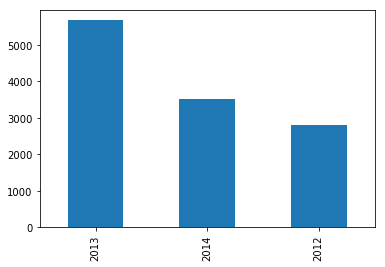

In [273]:
df_merge.creation_year.value_counts().plot(kind="bar")
plt.show()

In [274]:
pd.DataFrame(df_merge.groupby('creation_year')['adopted_user'].mean())

,adopted_user
creation_year,
2012,0.167322
2013,0.154158
2014,0.088744


We then look at the distribution of all users over the sources of creation, and also answer the question of whether the source of account creation could be a significant factor in the percentage of adopted users. We see that the very large number of users (ORG_INVITE) were invited to an organization as full members. We also see that users who were invited to join another user's personal workspace (PERSONAL_PROJECTS) were least likely to become adopted users. Though the number of users who created their accounts using Google authentication is not very large (SIGNUP_GOOGLE_AUTH), rather large percentage of them became adopted users.

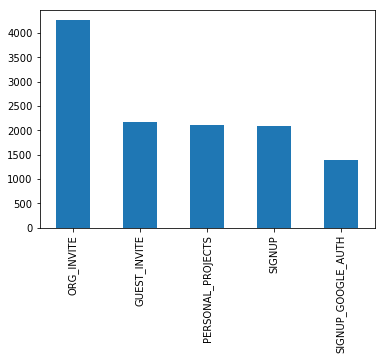

In [275]:
df_merge.creation_source.value_counts().plot(kind="bar")
plt.show()

In [276]:
pd.DataFrame(df_merge.groupby('creation_source')['adopted_user'].mean())

,adopted_user
creation_source,
GUEST_INVITE,0.170596
ORG_INVITE,0.134932
PERSONAL_PROJECTS,0.081478
SIGNUP,0.144705
SIGNUP_GOOGLE_AUTH,0.172563


We also see that there is a selected number of organizations membership in which  led to a high percentage of adopted users.

In [277]:
df_merge.groupby('org_id')['adopted_user'].mean().sort_values(ascending = False)

org_id
387    0.583333
235    0.461538
270    0.428571
399    0.384615
415    0.375000
400    0.375000
392    0.375000
117    0.363636
345    0.357143
318    0.352941
289    0.352941
291    0.352941
306    0.333333
381    0.333333
161    0.333333
395    0.333333
218    0.333333
82     0.333333
281    0.333333
177    0.315789
62     0.307692
305    0.307692
343    0.300000
352    0.300000
366    0.294118
273    0.294118
280    0.294118
225    0.294118
282    0.294118
238    0.294118
         ...   
362    0.052632
327    0.050000
158    0.050000
220    0.050000
349    0.045455
125    0.045455
229    0.043478
406    0.043478
143    0.043478
204    0.040000
26     0.037736
0      0.037618
86     0.028571
51     0.026316
412    0.000000
396    0.000000
394    0.000000
365    0.000000
355    0.000000
346    0.000000
329    0.000000
310    0.000000
307    0.000000
299    0.000000
279    0.000000
242    0.000000
237    0.000000
183    0.000000
151    0.000000
416    0.000000
Name: adopted_use

Finishing our exploratory data analysis, we notice that the month in which the account was created, whether a user opted into receiving marketing emails, was on the regular marketing email drip and was invited by someone else, are most likely not significant factors determining whether the user achieved adopted status. 

In [278]:
pd.DataFrame(df_merge.groupby('opted_in_to_mailing_list')['adopted_user'].mean())

,adopted_user
opted_in_to_mailing_list,
0,0.136243
1,0.143287


In [279]:
pd.DataFrame(df_merge.groupby('enabled_for_marketing_drip')['adopted_user'].mean())

,adopted_user
enabled_for_marketing_drip,
0,0.137049
1,0.143415


In [280]:
pd.DataFrame(df_merge.groupby('invited')['adopted_user'].mean())

,adopted_user
invited,
0,0.127709
1,0.146953


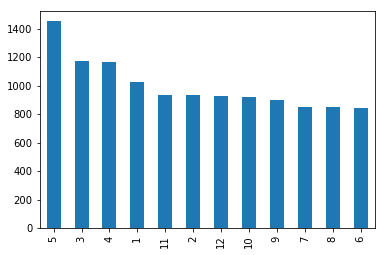

In [281]:
df_merge.creation_month.value_counts().plot(kind="bar")
plt.show()

In [282]:
pd.DataFrame(df_merge.groupby('creation_month')['adopted_user'].mean().sort_values(ascending = False))

,adopted_user
creation_month,
6,0.181926
10,0.175325
8,0.170188
11,0.161325
9,0.157603
2,0.146681
12,0.146237
1,0.145773
7,0.144366


### Predictive Modelling

We now do the predictive modelling to determine the factors that predict the future user adoption. We have a binary classification problem for the imbalanced dataset. We first pd.get_dummies to encode the 'creation_year' and 'creation_source' variables. 

In [283]:
df_merge['creation_year']  = df_merge['creation_year'].astype(str)
df_merge = pd.get_dummies(df_merge, columns= ['creation_year', 'creation_source'])

#df_merge.head()

Then, the column 'org_id' is very particular. It contains the number of organization that affects the percentage of adopted users. Thus rather than using the number, we will use the average percentage of adopted users affiliated with this organization. We will also drop the 'user_id' column for the purpose of making predictions.

In [284]:
df_merge = df_merge.join(df_merge.groupby('org_id')['adopted_user'].mean(), on='org_id', rsuffix='_pct_on_org_id')
df_merge = df_merge.rename(columns = {'adopted_user_pct_on_org_id':'effective_org_id'})


df_merge = df_merge.drop(['org_id', 'user_id'], axis = 1)

In [285]:
# create predictor andmstarget variables

X = df_merge.drop('adopted_user',axis =1).values
#X.info()

y = df_merge['adopted_user'].values

# create the list containing the relevant columns
column_names = df_merge.drop('adopted_user',axis =1).columns.values

We will use first the Gradient Boosting Classifier from the family of ensemble methods. The hyperparameters are determined using 5-fold cross-validation, and 70/30 percent of the dataset are used for training and test. 

In [286]:
%%time

from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(loss = 'deviance', warm_start = True)
X =  StandardScaler().fit_transform(X)
boost_params = {'subsample': [.1, .2, .4, .6, .8, 1.]}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42, stratify = y)

cv_gbc = GridSearchCV(gbc, boost_params, cv=5, scoring = 'roc_auc')

cv_gbc.fit(X_train, y_train)

y_pred_gbc = cv_gbc.predict(X_test)

print('The values of best parameters:',cv_gbc.best_params_)


gbc_training_score = cv_gbc.score(X_train, y_train)
gbc_test_score = cv_gbc.score(X_test, y_test)
gbc_confusion_matrix = confusion_matrix(y_test, y_pred_gbc)
gbc_classification_report = classification_report(y_test, y_pred_gbc)

print('Training score:', gbc_training_score)
print('Test score:', gbc_test_score)

print(gbc_confusion_matrix)
print(gbc_classification_report)

The values of best parameters: {'subsample': 0.6}
Training score: 0.999257773686
Test score: 0.998164624226
[[3070   33]
 [  31  466]]
             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99      3103
        1.0       0.93      0.94      0.94       497

avg / total       0.98      0.98      0.98      3600

Wall time: 35.3 s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


Let's now determine the feature importances in the Gradient Boosting Classifier.

In [289]:
# examining the feature importances

gbc_coeff = GradientBoostingClassifier(loss = 'deviance', warm_start = True)\
                                  .fit(X_train, y_train).feature_importances_

    
df_gbc_coeff = pd.DataFrame(column_names, columns = ['COLUMN_NAME'])
df_gbc_coeff['GBC_COEFF'] = np.transpose(gbc_coeff)

df_gbc_coeff.sort_values(by ='GBC_COEFF', ascending = False, inplace =True)

writer1 = pd.ExcelWriter('gbc_table.xlsx')
df_gbc_coeff.to_excel(writer1)
writer1.save()

df_gbc_coeff

,COLUMN_NAME,GBC_COEFF
4,visited_total,0.585028
13,effective_org_id,0.191056
3,creation_month,0.071849
7,creation_year_2014,0.061771
2,invited,0.020598
6,creation_year_2013,0.012973
10,creation_source_PERSONAL_PROJECTS,0.012377
11,creation_source_SIGNUP,0.012197
5,creation_year_2012,0.008763
8,creation_source_GUEST_INVITE,0.007380


We then use the Logistic Regreesion and examine the feature importances.

In [290]:
%%time

logreg = LogisticRegression(class_weight = 'balanced')
X =  StandardScaler().fit_transform(X)
parameters = {"C": [0.001, 0.01, 0.1, 1.], "penalty": ['l1', 'l2']}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42, stratify = y)

cv_logreg = GridSearchCV(logreg, param_grid = parameters, cv = 5, scoring = 'roc_auc')
cv_logreg.fit(X_train, y_train)

y_pred_logreg = cv_logreg.predict(X_test)

print('The value of C is:',cv_logreg.best_params_)

logreg_training_score = cv_logreg.score(X_train, y_train)
logreg_test_score = cv_logreg.score(X_test, y_test)
logreg_confusion_matrix = confusion_matrix(y_test, y_pred_logreg)
logreg_classification_report = classification_report(y_test, y_pred_logreg)

print('Training score:', logreg_training_score)
print('Test score:', logreg_test_score)

print(logreg_confusion_matrix)
print(logreg_classification_report)

The value of C is: {'C': 1.0, 'penalty': 'l1'}
Training score: 0.998699048499
Test score: 0.998139011316
[[3044   59]
 [  14  483]]
             precision    recall  f1-score   support

        0.0       1.00      0.98      0.99      3103
        1.0       0.89      0.97      0.93       497

avg / total       0.98      0.98      0.98      3600

Wall time: 6.75 s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


In [291]:
# examining the coefficients

logreg_coeff = LogisticRegression(class_weight = 'balanced', penalty = 'l1', 
                                  C = cv_logreg.best_params_['C']).fit(X_train, y_train).coef_

df_logit_coeff = pd.DataFrame(column_names, columns = ['COLUMN_NAME'])
df_logit_coeff['LOGREG_COEFF'] = np.transpose(np.abs(logreg_coeff))
df_logit_coeff.sort_values(by ='LOGREG_COEFF', ascending = False, inplace =True)

writer2 = pd.ExcelWriter('logreg_table.xlsx')
df_logit_coeff.to_excel(writer2)
writer2.save()

df_logit_coeff

,COLUMN_NAME,LOGREG_COEFF
4,visited_total,70.633359
13,effective_org_id,0.533653
1,enabled_for_marketing_drip,0.235791
3,creation_month,0.224233
10,creation_source_PERSONAL_PROJECTS,0.182699
7,creation_year_2014,0.157978
0,opted_in_to_mailing_list,0.140210
5,creation_year_2012,0.033838
12,creation_source_SIGNUP_GOOGLE_AUTH,0.030881
9,creation_source_ORG_INVITE,0.028164


We see that two prediction methods of different nature give accuracies that do not differ much, and both accuracies are high. Two methods lead to different relations between precision and recall. Looking at the feature importances, we can make the following conclusions.

1) In all methods the most important feature is the total number of logins. The more visits the user made, the higher probability that the user became an adopted one. This result is quite natural, but does not answer the question which other factors stimulated logins.

2) The second most important feature is 'effective_org_id' that gives the percentage of adopted users affiliated with a given organization. There are organizations with fraction of adopted users as high as 0.3-0.5; however there are organizations with  extremely small fraction of adopted users. In order to stimulate logins, and hence increase the number of adopted users, it is useful to understand what the interests of organizations with high and low percentages of adopted users are, and what the affiliated users are looking for. One needs to analyze other datasets with the information about the specific purposes of logins. 

3) It is interesting that the month when the account was created plays a rather important role in both methods. For some reasons, users who created their accounts in April and May have the lowest fractions of adopted users among them. At the same time, the number of accounts appeared in May is the largest.

4) The binary feature that tells us whether a given user was invited to join another user's personal workspace or not, plays the highest role among the features related to the source of account creation. The users who were invited to join another user are least likely to become adopted users.

5) Finally, one more important feature in both methods is whether the account was created in 2014 or not. 2014 is the latest year, and it is important to pay closer attention to other possibly relevant datasets related to this year. 